In [2]:
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras import backend as K
from keras.datasets import mnist
import keras.layers as L
from keras.models import Model
import tensorflow as tf

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28 * 28))
x_test = np.reshape(x_test, (x_test.shape[0], 28 * 28))

In [4]:
image_dim = 784
latent_dim = 2 # in order to produce visual represention of latent space
dim1 = 300
dim2 = 150

tf.reset_default_graph()
sess = tf.InteractiveSession()
K.set_session(sess)

nn_input = L.Input((image_dim,))

# reparametrization trick
def sample_latent(args):
    
    mu, log_var = args
    tensor_shape = K.shape(mu)
    batch_size, latent_dim = tensor_shape[0], tensor_shape[1]
    
    return mu + tf.exp(0.5 * log_var) * tf.random_normal((batch_size, latent_dim))

def create_encoder(dim1, dim2, latent_dim, input_dim):
    input_ = L.Input((input_dim, ))
    
    e_layer1 = L.Dense(dim1, activation='relu')(input_)
    e_layer1 = L.Dropout(0.1)(e_layer1)

    e_layer2 = L.Dense(dim2, activation='relu')(e_layer1)
    e_layer2 = L.Dropout(0.1)(e_layer2)

    e_layer3 = L.Dense(2 * latent_dim)(e_layer2)

    e_mu = L.Lambda(lambda h: h[:, :latent_dim])(e_layer3)
    e_log_var = L.Lambda(lambda h: h[:, latent_dim:])(e_layer3)

    z = L.Lambda(sample_latent, name='encoder')([e_mu, e_log_var])

    return Model(input_, [e_mu, e_log_var, z], name='encoder')

def create_decoder(dim1, dim2, latent_dim, output_dim):
    
    input_ = L.Input((latent_dim, ))
    
    d_layer1 = L.Dense(dim1, activation='relu')(input_)
    d_layer1 = L.Dropout(0.1)(d_layer1)
    
    d_layer2 = L.Dense(dim2, activation='relu')(d_layer1)
    d_layer2 = L.Dropout(0.1)(d_layer2)
    
    d_mu = L.Dense(output_dim)(d_layer2)
    d_log_var = L.Dense(output_dim)(d_layer2)
    
    return Model(input_, [d_mu, d_log_var])
    
encoder = create_encoder(dim1, dim2, latent_dim, image_dim)

encoder_output = encoder(nn_input)

encoder_mu = encoder_output[0]
encoder_log_var = encoder_output[1]

decoder = create_decoder(dim2, dim1, latent_dim, image_dim)
decoder_output = decoder(encoder_output[2])

vae = Model(nn_input, decoder_output[0])

nn_ouput = vae(nn_input)

In [5]:
# kullback leibler divergence
def kl(e_mu, e_log_var):
    
    kl_i = 0.5 * tf.reduce_sum(
            tf.pow(e_mu, 2) + 
            tf.exp(e_log_var) - 
            e_log_var - 
            1, 
        axis=1)
    
    return kl_i

# reconstruction error
def reconstruction_error(x, d_mu, d_log_var):
            
    re_i = tf.reduce_sum(tf.exp(d_log_var) + (x - d_mu) ** 2 / tf.exp(d_log_var), axis=1)
    re_i = -0.5 * (np.log(2 * np.pi) + re_i)
    
    return re_i

def lowebound(x, d_mu, d_log_var, e_mu, e_log_var):
    return K.mean(reconstruction_error(x, d_mu, d_log_var) - kl(e_mu, e_log_var))

lb = lowebound(nn_input, decoder_output[0], decoder_output[1], encoder_mu, encoder_log_var)

In [6]:
vae.compile(
    optimizer=keras.optimizers.Adam(lr=1e-04), 
    loss = lambda x, y: -lb
)

In [7]:
vae.fit(
    x_train, 
    x_train,
    epochs=80,
    batch_size=512,
    validation_data=(x_test, x_test), 
    verbose=1
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 4s 59us/step - loss: 321.1880 - val_loss: 200.6515
Epoch 2/80
60000/60000 [==============================] - 3s 49us/step - loss: 200.9651 - val_loss: 171.8054
Epoch 3/80
60000/60000 [==============================] - 3s 53us/step - loss: 179.5419 - val_loss: 159.3138
Epoch 4/80
60000/60000 [==============================] - 3s 49us/step - loss: 169.1734 - val_loss: 154.0483
Epoch 5/80
60000/60000 [==============================] - 3s 49us/step - loss: 162.3167 - val_loss: 149.9427
Epoch 6/80
60000/60000 [==============================] - 3s 49us/step - loss: 157.1047 - val_loss: 146.4931
Epoch 7/80
60000/60000 [==============================] - 3s 49us/step - loss: 152.7635 - val_loss: 143.4138
Epoch 8/80
60000/60000 [==============================] - 3s 49us/step - loss: 149.0162 - val_loss: 140.7430
Epoch 9/80
60000/60000 [==============================] - 3s 49us/step - loss:

60000/60000 [==============================] - 3s 51us/step - loss: 111.4267 - val_loss: 108.8680
Epoch 76/80
60000/60000 [==============================] - 3s 51us/step - loss: 111.3035 - val_loss: 108.6915
Epoch 77/80
60000/60000 [==============================] - 3s 51us/step - loss: 111.2329 - val_loss: 108.7209
Epoch 78/80
60000/60000 [==============================] - 3s 51us/step - loss: 111.1567 - val_loss: 108.6423
Epoch 79/80
60000/60000 [==============================] - 3s 51us/step - loss: 111.0595 - val_loss: 108.5425
Epoch 80/80
60000/60000 [==============================] - 3s 51us/step - loss: 110.9628 - val_loss: 108.5278


Checking reconstruction power on training set


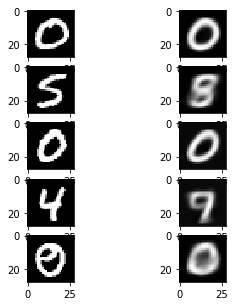

In [8]:
print("Checking reconstruction power on training set")
fig = plt.figure(figsize=(5, 5))

for i in range(5):
    example_id = np.random.randint(0, x_train.shape[0])
    example_image = np.reshape(x_train[example_id], (28, 28))
    pred = vae.predict(np.expand_dims(x_train[example_id], axis=0))
    
    fig.add_subplot(5, 2, 2 * i + 1)
    plt.imshow(example_image, cmap='Greys_r')
    fig.add_subplot(5, 2, 2 * (i + 1))
    plt.imshow(np.reshape(pred, (28, 28)), cmap='Greys_r')

Checking reconstruction power on testing set


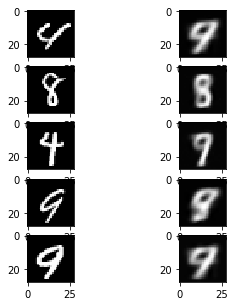

In [9]:
print("Checking reconstruction power on testing set")
fig = plt.figure(figsize=(5, 5))

for i in range(5):
    example_id = np.random.randint(0, x_test.shape[0])
    example_image = np.reshape(x_test[example_id], (28, 28))
    pred = vae.predict(np.expand_dims(x_test[example_id], axis=0))
    
    fig.add_subplot(5, 2, 2 * i + 1)
    plt.imshow(example_image, cmap='Greys_r')
    fig.add_subplot(5, 2, 2 * (i + 1))
    plt.imshow(np.reshape(pred, (28, 28)), cmap='Greys_r')

In [15]:
Z = np.random.normal(loc=[0, 0], scale=[1, 1], size=(100, 2))
d = decoder.predict(Z)[0]

In [16]:
# https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#### Samples from 2-D latent space

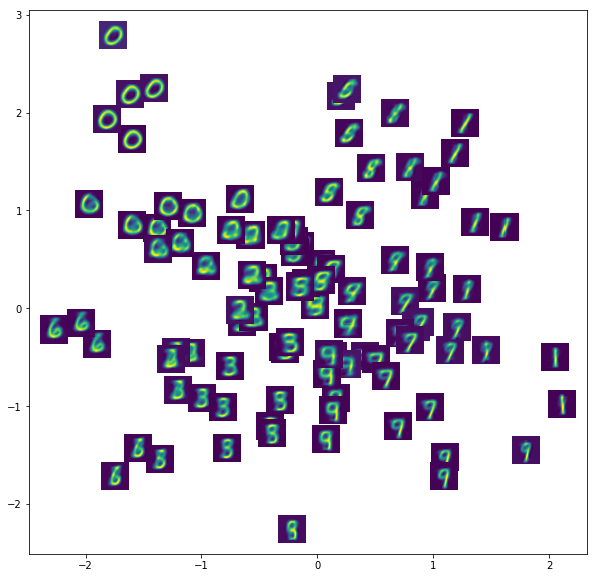

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for i, (x, y) in enumerate(Z):
    imscatter(x, y, np.reshape(d[i], (28, 28)), ax);